# TODO

* fix mouse ortholog gene lists used for tissue enrichment
* test on another platform
* try outlining combined network

**DONE**
* Write intro
* test with `rerun_analysis = False`
* test with `rerun_analysis = True`


# Introduction

This notebook analyses the proteins within the PCNet network that are proximal to only one of the two species BMI GWAS results. We examine the distribution of $NPS_r$ and $NPS_h$ scores for BMI to define thresholds for rat-specific and human-specific networks. We compare the tissue expression patterns of the species-specific network and the conserved BMI network. We then analyze these species-specific networks, along with the conserved network, in the context of a combined network of all proteins with high NPS in one or both species. 

**Figures produced in this notebook:**
* Figure 6a - Scatterplot showing the definition of subnetworks based on NPS scores.
* Figure 6b - Bar chart comparing the sources of genes in each of the subnetworks
* Figure 6c - Human tissue gene expression results for each of the subnetworks
* Figure 6d - Mouse tissue gene expression results for each of the subnetworks
* Figure 6e - Data for this figure is generated in this notebook, the hierarchy figure was produced in Cytoscape
* Extended Data Figure 5

**Note on re-running the analysis:**
* If `rerun_analysis==True` the hierarchical community detection and annotation of the combined network will be repeated. Because this process is not deterministic the results will vary slightly from the study results. 
* If `rerun_analysis==False` the hierarchy will be loaded from file.

In [5]:
rerun_analysis = False

# Set Up

## Libraries and paths

In [6]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from tqdm import tqdm
import cdapsutil
import ndex2
from scipy.stats import hypergeom
from statsmodels.stats.multitest import fdrcorrection
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

In [7]:
# Set up directory paths. Defaults to the Data/ and Figures/ folders within the repository.
cwd = os.path.dirname(os.getcwd())
DATADIR = os.path.join(cwd, "Data/")
FIGDIR = os.path.join(cwd, "Figures/")

In [8]:
sys.path.append(cwd)
from analysis_functions import *
from updated_netcoloc_functions import *

## Input Data

In [9]:
# load data, contains original subgraphs
data = pd.read_csv(DATADIR + "outputs/rat_human_BMI_all_NPS.tsv", sep = "\t", index_col=0)
data.head()

,NPS_r,NPS_h,NPS_hr
gene,,,
A1BG,0.125314,-0.488576,-0.061226
A1CF,2.540447,2.186042,5.553524
A2M,0.651845,-0.581848,-0.379275
A2ML1,-1.315517,-1.108608,1.458393
A3GALT2,-0.546107,-0.243477,0.132964


In [10]:
# load seed genes
seed_bin_human_BMI = pd.read_csv(DATADIR+"inputs/human_BMI_all_seed_genes.txt", header=None)[0].tolist()
print("Number of human BMI seeds:", len(seed_bin_human_BMI))

seed_bin_rat_BMI=pd.read_csv(DATADIR+'inputs/ratBMI_seed_genes.txt',sep='\t')['0'].tolist()
print("Number of rat BMI seeds:", len(seed_bin_rat_BMI))

Number of human BMI seeds: 1958
Number of rat BMI seeds: 295


In [11]:
# classify each gene based on seed gene status
data = data.assign(rat_seed=[1 if gene in seed_bin_rat_BMI else 0 for gene in data.index])
data = data.assign(human_seed=[1 if gene in seed_bin_human_BMI else 0 for gene in data.index])

# Defining species specific Networks

## Distributions of the species NPS

To determine appropriate thresholds for each species we examine the distribution of network proximity scores (NPS). 

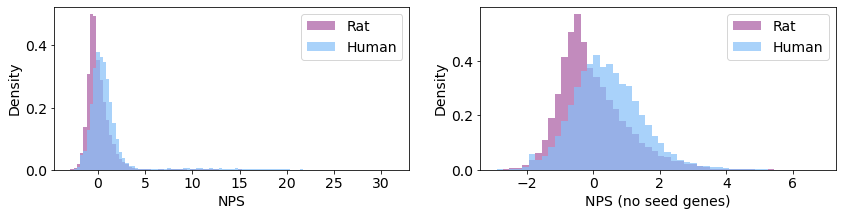

In [12]:
matplotlib.rcParams.update({'font.size': 14})
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))
_, bins, _ = ax1.hist(data.NPS_r, bins=100, alpha=0.7, density=True, label="Rat", color="#a95aa1")
_ = ax1.hist(data.NPS_h, bins=bins, alpha=0.7, density=True, label="Human", color="#85c0f9")
ax1.set_ylabel("Density")
ax1.set_xlabel("NPS")
ax1.legend()

_, bins, _ = ax2.hist(data[data.rat_seed==0].NPS_r, bins=50, alpha=0.7, density=True, label="Rat", color="#a95aa1")
_ = ax2.hist(data[data.human_seed==0].NPS_h, bins=bins, alpha=0.7, density=True, label="Human", color="#85c0f9")
ax2.set_ylabel("Density")
ax2.set_xlabel("NPS (no seed genes)")
ax2.legend()


In [13]:
data.loc[:, ("NPS_r", "NPS_h")].describe()

,NPS_r,NPS_h
count,18820.000000,18820.000000
mean,0.166117,1.064944
std,1.819963,3.034380
min,-2.908312,-3.953688
25%,-0.699091,-0.227384
50%,-0.220273,0.450951
75%,0.566990,1.240185
max,31.286290,34.273300


In [14]:
data[data.rat_seed==0].NPS_r.describe(percentiles=[0.5, 0.75, 0.8, 0.85, 0.9, 0.95])

count    18525.000000
mean        -0.013611
std          1.030633
min         -2.908312
50%         -0.237388
75%          0.518693
80%          0.729556
85%          1.005072
90%          1.354651
95%          1.952714
max          6.798332
Name: NPS_r, dtype: float64

In [15]:
data[data.human_seed==0].NPS_h.describe(percentiles=[0.5, 0.75, 0.8, 0.85, 0.9, 0.95])

count    16862.000000
mean         0.425921
std          1.047217
min         -3.953688
50%          0.348532
75%          1.069361
80%          1.240472
85%          1.464345
90%          1.742707
95%          2.219446
max          6.620334
Name: NPS_h, dtype: float64

## Set thresholds

Based on the above distributions we set:

* same-species threshold to be greater than $\mu_{sameSpecies} + \sigma_{sameSpecies}$
* other-species threshold to be less than $\mu_{otherSpecies}$
* combined thresholds to give a network between 500-1000 genes.

**Combo thresholds are used as follows:**  

Conserved: $z_{rat}\bullet z_{human} > combo$  
  
Rat Only: $z_{rat}\bullet (z_{human} - 1) < combo$  
  
Human Only: $(z_{rat}-1)\bullet z_{human} < combo$

In [16]:
# set thresholds:
conserved = {"rat":1, "human":1, "combo":3}
rat_only = {"rat":1, "human":0.5, "combo":-2}
human_only = {"rat":0, "human":1.5, "combo":-4}

## Identify subgraphs

In [17]:
def assign_sub_graph(data, rat_th=None, human_th=None, combo_th=None, th_dict=None, name="conserved"):
    if th_dict is not None:
        rat_th = th_dict["rat"]
        combo_th = th_dict["combo"]
        human_th = th_dict["human"]
    if "subgraph" not in data.columns:
        data = data.assign(subgraph="PCNet")
    if name == "rat":
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h < human_th) & (data.NPS_r * (data.NPS_h - 1) < combo_th)), 
                 ("subgraph")] = "Rat-Only"
    elif name == "human":
        data.loc[((data.NPS_r < rat_th) & (data.NPS_h > human_th) & ((data.NPS_r - 1)*(data.NPS_h) < combo_th)), 
                 ("subgraph")] = "Human-Only"
    else:
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h > human_th) & (data.NPS_hr > combo_th)), ("subgraph")] = "Conserved"
    return data

In [18]:
# classify each gene based on membership to sub networks
data = assign_sub_graph(data, th_dict = conserved, name="conserved")
data = assign_sub_graph(data, th_dict = rat_only, name="rat")
data = assign_sub_graph(data, th_dict = human_only, name="human")

In [19]:
# number of genes in each subnetwork
data.value_counts("subgraph", dropna=False)

subgraph
PCNet         16550
Human-Only      925
Rat-Only        688
Conserved       657
dtype: int64

In [20]:
# export the data
data.to_csv(DATADIR + "outputs/rat_only_human_only_networks.tsv", sep="\t")

## Visualize the species specific networks

In [21]:
def plot_species_nps(data, subgraph, th_dict=None, ax=None, legend=None, fontsize=7):
    x_points = [(i+0.0001)/10 for i in range(-50,250)]
    if subgraph == "conserved":
        cmap = {"Conserved": "#F5793A", **{k:"grey" for k in ["Rat-Only", "PCNet", "Human-Only"]}}
        combo_line = [th_dict["combo"]/x for x in x_points if x > th_dict["combo"]/25]
        ax.plot([x for x in x_points if x > th_dict["combo"]/25], combo_line, color="#f5793a", linewidth=1)
        ax.text(x=10, y=30, s="$NPS_r > "+str(th_dict["rat"])+"$", color="#a95aa1", fontsize=fontsize)
        ax.text(x=10, y=26, s="$NPS_h > "+str(th_dict["human"])+"$", color="#85c0f9", fontsize=fontsize)
        ax.text(x=10, y=22, s="$NPS_{hr} > "+str(th_dict["combo"])+"$", color="#f5793a", fontsize=fontsize)
    elif subgraph == "rat":
        cmap = {"Rat-Only": "#a95aa1", **{k:"grey" for k in ["Conserved", "PCNet", "Human-Only"]}}
        combo_line = [th_dict["combo"]/(x-1) for x in x_points if x < 1 + th_dict["combo"]/25]
        ax.plot([x for x in x_points if x < 1 + th_dict["combo"]/25], combo_line, color="#f5793a", linewidth=1)
        ax.text(x=10, y=30, s="$NPS_r > "+str(th_dict["rat"])+"$", color="#a95aa1", fontsize=fontsize)
        ax.text(x=10, y=26, s="$NPS_h < "+str(th_dict["human"])+"$", color="#85c0f9", fontsize=fontsize)
        ax.text(x=10, y=22, s="$NPS_r(NPS_h-1) < "+str(th_dict["combo"])+"$", color="#f5793a", fontsize=fontsize)
    elif subgraph == "human":
        cmap = {"Human-Only": "#85c0f9", **{k:"grey" for k in ["Rat-Only", "PCNet", "Conserved"]}}
        combo_line = [1 + th_dict["combo"]/x for x in x_points if x > th_dict["combo"]/-6]
        ax.plot([x for x in x_points if x > th_dict["combo"]/-6], combo_line, color="#f5793a", linewidth=1)
        ax.text(x=10, y=30, s="$NPS_r < "+str(th_dict["rat"])+"$", color="#a95aa1", fontsize=fontsize)
        ax.text(x=10, y=26, s="$NPS_h > "+str(th_dict["human"])+"$", color="#85c0f9", fontsize=fontsize)
        ax.text(x=10, y=22, s="$NPS_h(NPS_r-1) < "+str(th_dict["combo"])+"$", color="#f5793a", fontsize=fontsize)
    else:
        cmap = {"Conserved": "#F5793A","Rat-Only": "#a95aa1", "Human-Only": "#85c0f9", "PCNet":"grey" }
    
    sns.scatterplot(data=data, x="NPS_h", y="NPS_r", hue="subgraph", palette=cmap, s=2, ax=ax, markers=True, alpha=0.8,
                legend=legend)
    if th_dict is not None:
        ax.hlines(y=th_dict["rat"], xmin=-5, xmax=25, color="#a95aa1", alpha=1, zorder=4, linewidth=1)
        ax.vlines(x=th_dict["human"], ymin=-5, ymax=25, color="#85c0f9", alpha=1, zorder=3, linewidth=1)
    ax.set_ylabel("NPS$_r$", fontsize=fontsize)
    ax.set_xlabel("NPS$_h$", fontsize=fontsize)
    ax.spines['left'].set(position=('data', 0.0), zorder=2)
    ax.spines['bottom'].set(position=('data', 0.0), zorder=2)
    ax.spines['top'].set_position(('data', 0.0))
    ax.spines['right'].set_position(('data', 0.0))
    ax.set_xticks([ 5, 10, 15, 20, 25, 30])
    ax.set_xticklabels(labels=[ 5, 10, 15, 20, 25, 30], fontsize=fontsize, zorder=10)
    ax.set_yticks([ 5, 10, 15, 20, 25, 30])
    ax.set_yticklabels(labels=[ 5, 10, 15, 20, 25, 30], fontsize=fontsize, zorder=10)

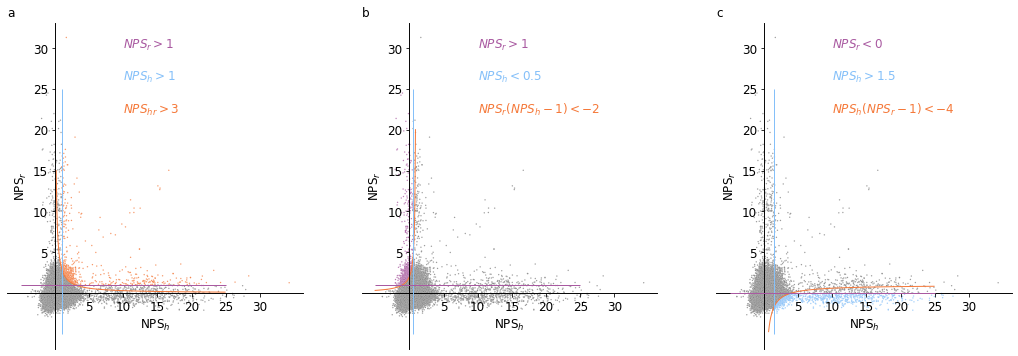

In [22]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
plot_species_nps(data, "conserved", conserved, ax1, fontsize=12)
plot_species_nps(data, "rat", rat_only, ax2, fontsize=12)
plot_species_nps(data, "human", human_only, ax3, fontsize=12)
ax1.set_title("a", loc="left", fontsize=12)
ax2.set_title("b", loc="left", fontsize=12)
ax3.set_title("c", loc="left", fontsize=12)
plt.savefig(FIGDIR + "EX5_definition_of_networks.png", dpi=400, bbox_inches="tight")

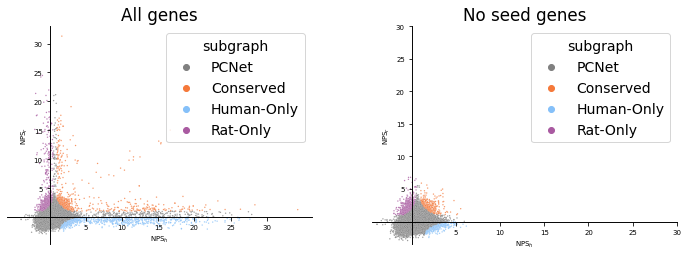

In [23]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
plot_species_nps(data, "all", ax=ax1, legend="brief")
plot_species_nps(data[data.rat_seed+data.human_seed==0], "all", ax=ax2, legend="brief")
_ = ax2.set_title("No seed genes")
_ = ax1.set_title("All genes")

## Assess seed gene fractions

In [24]:
data = data.assign(overlapping_seeds=1*(data.rat_seed + data.human_seed==2))
data.head()

,NPS_r,NPS_h,NPS_hr,rat_seed,human_seed,subgraph,overlapping_seeds
gene,,,,,,,
A1BG,0.125314,-0.488576,-0.061226,0,0,PCNet,0
A1CF,2.540447,2.186042,5.553524,0,0,Conserved,0
A2M,0.651845,-0.581848,-0.379275,0,0,PCNet,0
A2ML1,-1.315517,-1.108608,1.458393,0,0,PCNet,0
A3GALT2,-0.546107,-0.243477,0.132964,0,1,PCNet,0


In [25]:
subgraph_stats = data.groupby("subgraph").sum().loc[:, ("rat_seed", "human_seed", "overlapping_seeds")]

In [26]:
subgraph_stats = subgraph_stats.join(data.groupby("subgraph").count().loc[:, "NPS_r"])
subgraph_stats = subgraph_stats.rename(columns={"NPS_r":"count"})
subgraph_stats["Network"] = subgraph_stats["count"].values - subgraph_stats.loc[:,("rat_seed", "human_seed", "overlapping_seeds")].sum(axis=1).values
subgraph_stats.drop(columns=["count"], inplace=True)
subgraph_stats = subgraph_stats.loc[:,( "human_seed", "overlapping_seeds","rat_seed", "Network") ]

In [27]:
subgraph_stats["Network (Conserved)"] = 0
subgraph_stats.loc["Conserved", ("Network (Conserved)")] = subgraph_stats.loc["Conserved", ("Network")]
subgraph_stats["Network (Rat)"] = 0
subgraph_stats.loc["Rat-Only", ("Network (Rat)")] = subgraph_stats.loc["Rat-Only", ("Network")]
subgraph_stats["Network (Human)"] = 0
subgraph_stats.loc["Human-Only", ("Network (Human)"
                                 )] = subgraph_stats.loc["Human-Only", ("Network")]
subgraph_stats.drop(columns = ["Network"], inplace=True)

In [28]:
subgraph_stats

,human_seed,overlapping_seeds,rat_seed,Network (Conserved),Network (Rat),Network (Human)
subgraph,,,,,,
Conserved,228,21,114,294,0,0
Human-Only,567,0,0,0,0,358
PCNet,1136,3,52,0,0,0
Rat-Only,27,5,129,0,527,0


In [29]:
subgraph_stats.columns = ["Human Seed", "Shared Seed", "Rat Seed", "Network (Conserved)","Network (Rat)","Network (Human)"]

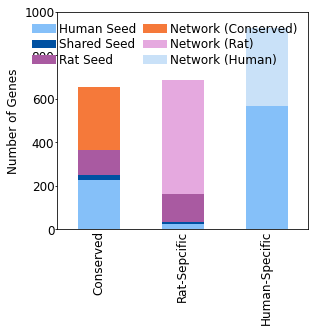

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4.5,4))
subgraph_stats.loc[["Conserved", "Rat-Only", "Human-Only"]].plot(kind="bar", stacked=True, ax=ax,
                                                                 color=["#85c0f9", "#0051a2","#a95aa1", "#F5793a", "#e5a9df", "#c9e1f8"])
plt.legend(ncol=2, handletextpad=0.3, labelspacing=0.2, borderpad=0.4, columnspacing=0.5, fontsize=12, frameon=False)
#plt.ylim((0, 1300))
#ax.get_legend().remove()
plt.xticks(fontsize=12)
plt.yticks([0,200, 400, 600, 800, 1000],fontsize=12)
ax.set_xticklabels(labels=["Conserved", "Rat-Sepcific", "Human-Specific"])
plt.xlabel(None)
ax.tick_params(axis='x', pad=1, length=0)
ax.tick_params(axis='y', pad=1, length=2)
plt.ylabel("Number of Genes", fontsize=12)
plt.savefig(FIGDIR + "6b_species_specific_bars.png", dpi=400, bbox_inches="tight")

# Tissue enrichments of conserved & species specific networks

Tissue enrichments were done using:
* Human: http://genetics.wustl.edu/jdlab/tsea/
* Mouse: https://tissueenrich.gdcb.iastate.edu/

For mouse tissue enrichments, all genes were converted to mouse orthologs using the MGD data downloaded for functional enrichment. 

In [31]:
def to_mouse_genes(gene_list, mgi_df):
    orthos = mgi_df.loc[mgi_df.human_ortholog.isin(gene_list), ("gene_name")].unique()
    return orthos

## Get gene lists for each subnetwork

In [32]:
# create lists of genes within the three subgraphs
with open(DATADIR + "outputs/subgraph_genes_conserved.txt", 'w') as fp:
    fp.write('\n'.join(data.loc[data.subgraph=="Conserved"].index.values))
with open(DATADIR + "outputs/subgraph_genes_rat.txt", 'w') as fp:
    fp.write('\n'.join(data.loc[data.subgraph=="Rat-Only"].index.values))
with open(DATADIR + "outputs/subgraph_genes_human.txt", 'w') as fp:
    fp.write('\n'.join(data.loc[data.subgraph=="Human-Only"].index.values))

In [33]:
mgi_df = load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt',
                                         map_using="mgi", update=False, data_loc=DATADIR+"Reference/")

In [34]:
# create subgraph lists with mouse orthologs
with open(DATADIR + "outputs/subgraph_genes_conserved_mouse_ortho.txt", 'w') as fp:
    fp.write('\n'.join(to_mouse_genes(data.loc[data.subgraph=="Conserved"].index.values, mgi_df)))
with open(DATADIR + "outputs/subgraph_genes_rat_mouse_ortho.txt", 'w') as fp:
    fp.write('\n'.join(to_mouse_genes(data.loc[data.subgraph=="Rat-Only"].index.values, mgi_df)))
with open(DATADIR + "outputs/subgraph_genes_human_mouse_ortho.txt", 'w') as fp:
    fp.write('\n'.join(to_mouse_genes(data.loc[data.subgraph=="Human-Only"].index.values, mgi_df)))

## Import tissue enrichment results

In [35]:
# read in the results of tissue enrichments in human tissue
human_te_files = {"C":DATADIR+"outputs/C_TSEA.txt", "R":DATADIR+"outputs/R_TSEA.txt", "H":DATADIR+"outputs/H_TSEA.txt"}
human_te = {}
for subgraph in human_te_files:
    tsea = pd.read_csv(human_te_files[subgraph], index_col=0, sep="\t")
    tsea[subgraph+"_FDR"] = tsea["0.05"].apply(lambda x: -1 * np.log10(float(x.split(" ")[2])))
    human_te[subgraph] = tsea.loc[:, (subgraph+"_FDR")]
human_te = pd.DataFrame.from_dict(human_te)

In [36]:
# read in the results of tissue enrichments in mouse tissue
mouse_te_files = {"C":DATADIR+"outputs/C_TSEA_mouse_ENCODE.tsv", 
                  "R":DATADIR+"outputs/R_TSEA_mouse_ENCODE.tsv", 
                  "H":DATADIR+"outputs/H_TSEA_mouse_ENCODE.tsv"}
mouse_te = {}
for subgraph in mouse_te_files:
    tsea = pd.read_csv(mouse_te_files[subgraph], index_col=0, sep="\t")
    tsea[subgraph+"_FDR"] = -1* np.log10(fdrcorrection(10**(-1* tsea["-Log10PValue"]))[1])
    mouse_te[subgraph] = tsea.loc[:, (subgraph+"_FDR")]
mouse_te = pd.DataFrame.from_dict(mouse_te)

## Visualize tissue enrichment results

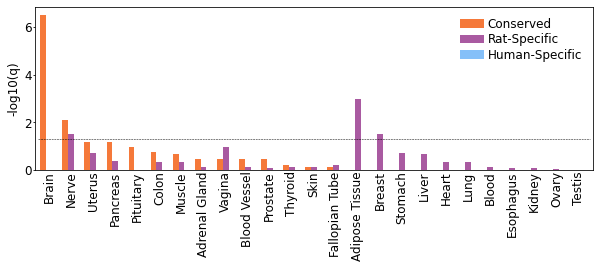

In [37]:
human_te.columns = ["Conserved", "Rat-Specific", "Human-Specific"]
human_te = human_te.sort_values(by=["Conserved", "Rat-Specific"], ascending=False)
fig, ax = plt.subplots(figsize=(10,3))
human_te.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"], fontsize=12)
ax.set_ylabel("-log10(q)", fontsize=12)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=12, frameon=False,handletextpad=0.3, labelspacing=0.2 )
plt.tick_params(axis='x', pad=1, length=0)
plt.tick_params(axis='y', pad=1, length=2)
plt.yticks([0,2,4,6])
plt.savefig(FIGDIR+"6c_tissue_enrichment_human_GTEx.png", bbox_inches="tight", dpi=400)


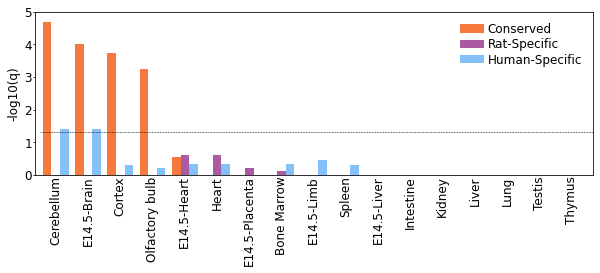

In [38]:
mouse_te.columns = ["Conserved", "Rat-Specific", "Human-Specific"]
mouse_te = mouse_te.sort_values(by=["Conserved", "Rat-Specific", "Human-Specific"], ascending=False)
fig, ax = plt.subplots(figsize=(10,3))
mouse_te.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"], fontsize=12)
ax.set_ylabel("-log10(q)", fontsize=12)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=12, frameon=False,handletextpad=0.3, labelspacing=0.2 )
plt.tick_params(axis='x', pad=1, length=0)
plt.tick_params(axis='y', pad=1, length=2)
plt.yticks([0,1,2,3,4,5])
#plt.title("Enrichment of Tissue-Specific Genes from mouse ENCODE")
plt.savefig(FIGDIR+"6d_tissue_enrichment_mouse_ENCODE.png", bbox_inches="tight", dpi=400)


# Hierarchical Community Detection of Species Specific Networks

## Define the combined network

To create a unified network for analyzing conserved, rat-specific and human-specific genes we take all genes with $NPS_r > 1$ **or** $NPS_h$ > 1.5 - corresponding to the same-species thresholds used to define the rat-specific and human-specific networks. 

In [39]:
pc_nodes, G = load_pcnet()

number of nodes:
18820

number of edges:
2693109


In [40]:
# extract just the nodes meeting our criteria
G_all = G.subgraph(nodes=data.loc[(data.NPS_r > rat_only["rat"]) | (data.NPS_h > human_only["human"])].index)

In [41]:
G_all_cx = ndex2.create_nice_cx_from_networkx(G_all)
G_all_cx.set_name("Combined Rat-Human-Conserved BMI Network")

In [42]:
# Save the network to NDEx
username = getpass("Username:")
passwd = getpass("Password:")
client = ndex2.client.Ndex2(username=username, password=passwd)
client.save_new_network(G_all_cx.to_cx(), visibility='PRIVATE')

Username:········
Password:········
Generating CX


'https://www.ndexbio.org/v2/network/9a36a1c1-2fae-11ed-ac45-0ac135e8bacf'

In [43]:
print("Number of genes in combined network:", len(G_all.nodes))

Number of genes in combined network: 6025


In [44]:
data["in_combined"] = data.apply(lambda x: (x.NPS_r > 1) or (x.NPS_h > 1.5), axis=1)

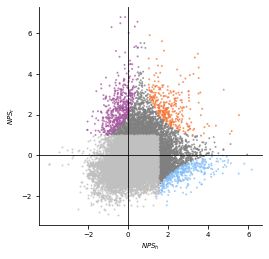

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
cmap = {"Conserved": "#F5793A","Rat-Only": "#a95aa1", "Human-Only": "#85c0f9", "PCNet":"grey" }
sns.scatterplot(data=data[((data.rat_seed+data.human_seed==0) & (data.in_combined))], x="NPS_h", y="NPS_r", hue="subgraph", palette=cmap, 
                s=3, ax=ax, markers=True, alpha=0.8, edgecolor='face')
sns.scatterplot(data=data[((data.rat_seed+data.human_seed==0) & (~data.in_combined))], x="NPS_h", y="NPS_r", color='silver',
                s=3, ax=ax, markers=True, alpha=0.8, edgecolor='face')
ax.set_xticks([ -2 ,0, 2, 4, 6])
ax.set_yticks([ -2 ,0, 2, 4, 6])
ax.tick_params(labelsize=7)
plt.xlabel("$NPS_h$", fontsize=7)
plt.ylabel("$NPS_r$", fontsize=7)
ax.get_legend().remove()
#plt.legend(ncol=1, handletextpad=0.05, labelspacing=0.1, borderpad=0.4, fontsize=7, frameon=False, markerscale=0.5,
#          labels=["Combined Network", "Conserved", "Human-Specific", "Rat-Specific"])
ax.spines['top'].set_position(('data', 0.0))
ax.spines['right'].set_position(('data', 0.0))
plt.savefig(FIGDIR+"6a_subnetworks_no_seeds.png",  dpi=400, bbox_inches="tight")


## Perform hierarchical community detection

In [46]:
if rerun_analysis:
    cd = cdapsutil.CommunityDetection()
    G_all_hier = cd.run_community_detection(G_all_cx, algorithm='hidefv1.1beta',arguments={'--maxres':str(10)})
    print('Hierarchy name: ' + str(G_all_hier.get_name()))
    print('# nodes: ' + str(len(G_all_hier.get_nodes())))
    print('# edges: ' + str(len(G_all_hier.get_edges())))
    all_hier_nx = G_all_hier.to_networkx(mode='default')
    nodes = all_hier_nx.nodes()
# print out interactome num nodes and edges for diagnostic purposes
    print('number of nodes:')
    print(len(all_hier_nx.nodes()))
    print('\nnumber of edges:')
    print(len(all_hier_nx.edges()))
# add node attributes to dataframe for easier access
    all_hier_df = pd.DataFrame.from_dict(dict(all_hier_nx.nodes(data=True)), orient='index')
    all_hier_df['system_ID']=all_hier_df.index.tolist()
# fix column types
    all_hier_df['CD_MemberList_Size']=[int(x) for x in all_hier_df['CD_MemberList_Size'].tolist()]
    all_hier_df['HiDeF_persistence']=[int(x) for x in all_hier_df['HiDeF_persistence'].tolist()]
    all_hier_df.set_index("name", inplace=True, drop=True)
    all_hier_df.index.name=None
else:
    # load the hierarchy data
    all_hier_df = pd.read_csv(DATADIR + "outputs/species_combined_hierarchy_data.tsv", sep="\t", index_col=0)

## Annotate the hiearchy with GO terms

In [47]:

def filter_go_annotations(go_df, term_min=50, term_max=1000, p_th=1e-4, min_intersection=3):
    go_df = go_df[(go_df['term_size'] <= term_max) & (go_df['term_size'] >= term_min)]
    go_df = go_df[go_df['intersection_size'] >= min_intersection]
    go_df = go_df[go_df['p_value'] < p_th] # set a stringent pvalue threshold
    go_df['sum_PR'] = go_df['recall'] + go_df['precision']
    go_df = go_df.sort_values('sum_PR',ascending=False)
    return go_df

In [48]:
# Annotate with GO terms
# gprofiler annotation of clusters
if rerun_analysis:
    system_names = {}
    all_results = []
    for comm in tqdm(all_hier_df.index.tolist()):
        if isinstance(all_hier_df['CD_MemberList'].loc[comm], str):
            focal_genes=all_hier_df['CD_MemberList'].loc[comm].split(' ')
        else:
            focal_genes=all_hier_df['CD_MemberList'].loc[comm]
        print(comm,":", len(focal_genes))
        system_names[comm] = comm # default is to keep identifier as name, will be replaced if confident annotation available
        if len(focal_genes)>2:
            # sometimes we get server errors, can usually be resolved by just retrying the submission
            retry=True
            attempts=1
            while retry and attempts < 10:
                try:
                    gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['GO:BP'], no_evidences=False))
                    retry=False
                    if len(gp_temp)>0: # make sure data is not empty
                        gp_temp["community"] = comm
                        all_results.append(gp_temp)
                        gp_temp = filter_go_annotations(gp_temp, 50, 1000, 1e-3, 3)
                        if len(gp_temp)>1:
                            system_names[comm] = gp_temp.head(1)['name'].tolist()[0]
                    #all_results.append(gp_temp)
                except AssertionError:
                    attempts += 1
                    print("Server error. Retrying....")
                 
    go_results = pd.concat(all_results)
    go_results.to_csv(DATADIR+"outputs/rerun_species_combined_hierarchy_GO_enrichment.tsv", index=True, sep="\t")
            
else:
    go_results = pd.read_csv(DATADIR+ "outputs/species_combined_hierarchy_GO_enrichment.tsv", index_col=None, sep="\t")
    go_results = filter_go_annotations(go_results, 50, 1000, 1e-3, 3)
    system_names = {}
    for comm in all_hier_df.index.tolist():
        if comm in go_results['community'].tolist():
            system_names[comm] = go_results[go_results['community']==comm]['name'].tolist()[0]
        else:
            system_names[comm] = comm

In [49]:
# Save the system annotations
pd.DataFrame.from_dict(system_names, orient="index").to_csv(DATADIR + "outputs/species_combined_hierarchy_system_names.tsv", sep="\t")

## Annotate the global systems map

In [50]:
# split the gene list into a list object
all_hier_df["CD_MemberList"] = all_hier_df.CD_MemberList.apply(lambda x: x.split(" "))

In [51]:
data.head()

,NPS_r,NPS_h,NPS_hr,rat_seed,human_seed,subgraph,overlapping_seeds,in_combined
gene,,,,,,,,
A1BG,0.125314,-0.488576,-0.061226,0,0,PCNet,0,False
A1CF,2.540447,2.186042,5.553524,0,0,Conserved,0,True
A2M,0.651845,-0.581848,-0.379275,0,0,PCNet,0,False
A2ML1,-1.315517,-1.108608,1.458393,0,0,PCNet,0,False
A3GALT2,-0.546107,-0.243477,0.132964,0,1,PCNet,0,False


In [52]:
conserved_net_genes = data.loc[(data.subgraph == "Conserved") & (data.rat_seed + data.human_seed + data.overlapping_seeds == 0)].index.values
rat_net_genes = data.loc[(data.subgraph == "Rat-Only") & (data.rat_seed + data.human_seed + data.overlapping_seeds == 0)].index.values
human_net_genes = data.loc[(data.subgraph == "Human-Only") & (data.rat_seed + data.human_seed + data.overlapping_seeds == 0)].index.values

In [53]:
# Fraction of genes from each subnetwork
all_hier_df["frac_conserved"] = all_hier_df.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.subgraph=="Conserved")].index.values)/len(x))
all_hier_df["frac_rat"] = all_hier_df.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.subgraph=="Rat-Only")].index.values)/len(x))
all_hier_df["frac_human"] = all_hier_df.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.subgraph=="Human-Only")].index.values)/len(x))

In [54]:
hier_fractions = all_hier_df.loc[:,("CD_MemberList", "CD_MemberList_Size")]

In [55]:
hier_fractions["h_seed"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.human_seed==1) & (data.overlapping_seeds==0)]))
hier_fractions["hr_seed"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.overlapping_seeds==1)]))
hier_fractions["r_seed"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.rat_seed==1) & (data.overlapping_seeds==0)]))
hier_fractions["h_net"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.index.isin(human_net_genes))]))
hier_fractions["c_net"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.index.isin(conserved_net_genes))]))
hier_fractions["r_net"] = hier_fractions.CD_MemberList.apply(lambda x: len(data.loc[(data.index.isin(x)) & (data.index.isin(rat_net_genes))]))

In [56]:
hier_fractions.to_csv(DATADIR+"outputs/species_subnetwork_combined_hierarchy_fractions.tsv", sep="\t")

In [57]:
# significance of the number of genes from each subnetwork
M = 6025
all_hier_df["p_rat"] = all_hier_df.apply(lambda x: hypergeom.sf(M=6025, n=688, N=x.CD_MemberList_Size, 
                                                                k=int(x.frac_rat*x.CD_MemberList_Size)), axis=1)
all_hier_df["p_human"] = all_hier_df.apply(lambda x: hypergeom.sf(M=6025, n=925, N=x.CD_MemberList_Size, 
                                                                k=int(x.frac_human*x.CD_MemberList_Size)), axis=1)
all_hier_df["p_conserved"] = all_hier_df.apply(lambda x: hypergeom.sf(M=6025, n=657, N=x.CD_MemberList_Size, 
                                                                k=int(x.frac_conserved*x.CD_MemberList_Size)), axis=1)

In [58]:
# perform multiple hypothesis correction for each test
all_hier_df["q_rat"] = fdrcorrection(all_hier_df["p_rat"])[1]
all_hier_df["q_human"] = fdrcorrection(all_hier_df["p_human"])[1]
all_hier_df["q_conserved"] = fdrcorrection(all_hier_df["p_conserved"])[1]

In [59]:
# identify the significantly over-represented communities
all_hier_df["sig_rat"] = 1 * (all_hier_df["q_rat"] < 0.05)
all_hier_df["sig_human"] = 1 * (all_hier_df["q_human"] < 0.05)
all_hier_df["sig_conserved"] = 1 * (all_hier_df["q_conserved"] < 0.05)
all_hier_df["sig_network"] = ""
all_hier_df.loc[all_hier_df["sig_rat"] == 1, "sig_network"] += "rat"
all_hier_df.loc[all_hier_df["sig_human"] == 1, "sig_network"] += "human"
all_hier_df.loc[all_hier_df["sig_conserved"] == 1, "sig_network"] += "conserved"

In [60]:
if rerun_analysis:
    # assign these attributes to the combined hierarchy
    for idx, node in G_all_hier.get_nodes():
        for attr in ["frac_conserved", "frac_rat", "frac_human", "q_conserved","q_rat", "q_human", "sig_rat", "sig_network"]:
            G_all_hier.set_node_attribute(idx, attr, all_hier_df.loc[node['n'], attr])
        G_all_hier.set_node_attribute(idx, "Annotation", system_names[node['n']])
    G_all_hier.set_name("Combined Rat-Human-Conserved BMI Hierarchy")

## Upload the combined systems map

In [61]:
if rerun_analysis:
    username = getpass("Username:")
    passwd = getpass("Password:")
    client = ndex2.client.Ndex2(username=username, password=passwd)
    client.save_new_network(G_all_hier.to_cx(), visibility='PRIVATE')

In [62]:
# save the table of hierarchy data
if rerun_analysis:
    all_hier_df.to_csv(DATADIR + "outputs/rerun_species_combined_hierarchy_data.tsv", sep="\t")

## Visualize over-represented communities

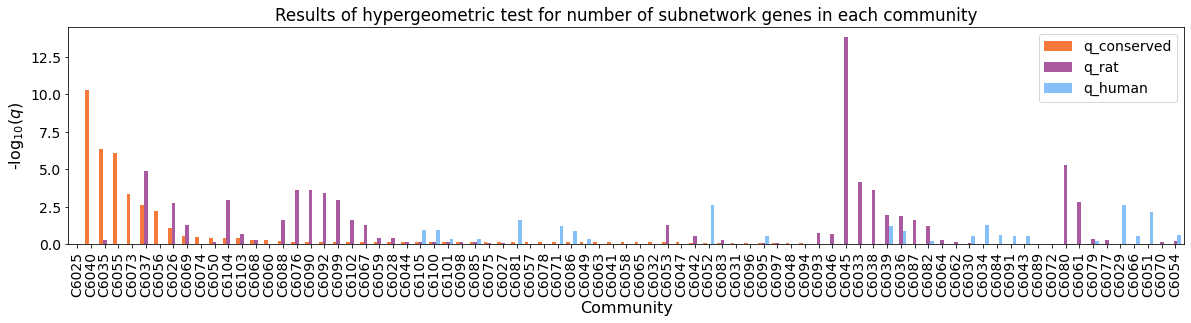

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
plot_data = all_hier_df.sort_values(by=["q_conserved", "q_rat", "q_human"]).loc[:, ("q_conserved", "q_rat", "q_human")]
(-1 * np.log10(plot_data)).plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"])
plt.xlabel("Community", fontsize=16)
_ = plt.ylabel("-log$_{10}(q)$", fontsize=16)
_ = plt.title("Results of hypergeometric test for number of subnetwork genes in each community")

# Scaled Figures

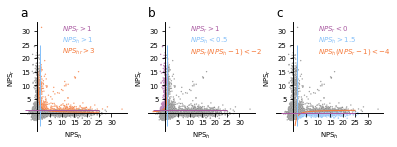

In [64]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 2))
plot_species_nps(data, "conserved", conserved, ax1)
plot_species_nps(data, "rat", rat_only, ax2)
plot_species_nps(data, "human", human_only, ax3)
ax1.set_title("a", loc="left", fontsize=12)
ax2.set_title("b", loc="left", fontsize=12)
ax3.set_title("c", loc="left", fontsize=12)
plt.savefig(FIGDIR + "definition_of_networks.png", dpi=400, bbox_inches="tight")


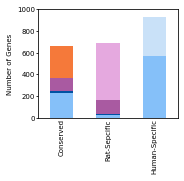

In [65]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(2.5,2))
subgraph_stats.loc[["Conserved", "Rat-Only", "Human-Only"]].plot(kind="bar", stacked=True, ax=ax,
                                                                 color=["#85c0f9", "#0051a2","#a95aa1", "#F5793a", "#e5a9df", "#c9e1f8"])
plt.legend(ncol=2, handletextpad=0.3, labelspacing=0.2, borderpad=0.4, columnspacing=0.5, fontsize=7, frameon=False)
#plt.ylim((0, 1300))
ax.get_legend().remove()
plt.xticks(fontsize=7)
plt.yticks([0,200, 400, 600, 800, 1000],fontsize=7)
ax.set_xticklabels(labels=["Conserved", "Rat-Sepcific", "Human-Specific"])
plt.xlabel(None)
ax.tick_params(axis='x', pad=1, length=0)
ax.tick_params(axis='y', pad=1, length=2)
plt.ylabel("Number of Genes", fontsize=7)
plt.savefig(FIGDIR+"species_specific_bars_scaled.png",  dpi=400, bbox_inches="tight")

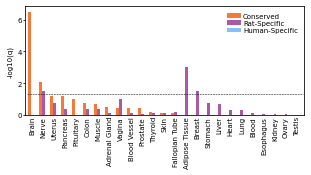

In [66]:
human_te.columns = ["Conserved", "Rat-Specific", "Human-Specific"]
human_te = human_te.sort_values(by=["Conserved", "Rat-Specific"], ascending=False)
fig, ax = plt.subplots(figsize=(5,2))
human_te.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"], fontsize=7)
ax.set_ylabel("-log10(q)", fontsize=7)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=7, frameon=False,handletextpad=0.3, labelspacing=0.2 )
plt.tick_params(axis='x', pad=1, length=0)
plt.tick_params(axis='y', pad=1, length=2)
plt.yticks([0,2,4,6])
plt.savefig(FIGDIR+"tissue_enrichment_human_GTEx_scaled.png", bbox_inches="tight", dpi=400)


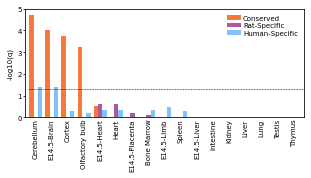

In [67]:
mouse_te.columns = ["Conserved", "Rat-Specific", "Human-Specific"]
mouse_te = mouse_te.sort_values(by=["Conserved", "Rat-Specific", "Human-Specific"], ascending=False)
fig, ax = plt.subplots(figsize=(5,2))
mouse_te.plot.bar(ax=ax, width=0.8, color=["#f5793a", "#a95aa1", "#85c0f9"], fontsize=7)
ax.set_ylabel("-log10(q)", fontsize=7)
ax.set_xlabel(None)
plt.hlines(-1 *np.log10(0.05),-0.5, 24.5, color="black", linestyle="dashed", linewidth=0.5)
plt.legend(fontsize=7, frameon=False,handletextpad=0.3, labelspacing=0.2 )
plt.tick_params(axis='x', pad=1, length=0)
plt.tick_params(axis='y', pad=1, length=2)
plt.yticks([0,1,2,3,4,5])
#plt.title("Enrichment of Tissue-Specific Genes from mouse ENCODE")
plt.savefig(FIGDIR+"tissue_enrichment_mouse_ENCODE_scaled.png", bbox_inches="tight", dpi=400)